Binary Classification using Logistic Discrimination

Here is my assignment 1, this is the notebook exported to pdf, the code is on github at this link : https://github.com/CrazierThanYou/FYS-2021/tree/86411aeca807c4585a032c091034545b7ca31c08/Assignments/Assignment1.

In this assignment, we will use logistic discrimination to classify songs into two categories: "Pop" and "Classical." We'll utilize numpy and pandas to handle the data, and we'll implement a logistic regression model from scratch to classify the songs. We'll also visualize the data and the classifier's decision boundary using matplotlib.

In [37]:
import numpy as np
import pandas as pd
import math as m
import matplotlib.pyplot as plt 

np.set_printoptions(precision=4, suppress=True)

We begin by loading the dataset, SpotifyFeatures.csv, using the pandas library. The dataset contains several features of songs, but we are particularly interested in the genre of the songs, as well as two features: liveness and loudness.

We load the dataset and retrieve the number of tracks (rows) and features (columns) it contains.

In [38]:
table = pd.read_csv('./SpotifyFeatures.csv')
nb_track, nb_feature = table.shape
print("Tracks =", nb_track, "\nFeatures =", nb_feature)

Tracks = 232725 
Features = 18


After loading the data, we filter out the tracks belonging to the Pop and Classical genres. We also retain only the features we are interested in: liveness, loudness, and genre (our target variable). In this process, we label Pop songs with 1 and Classical songs with 0 to make them suitable for binary classification.

In [39]:
# List for the tracks pop and classical
filter_track =[]

# Loop to find the tracks and to change their genre to integer
for index, track in table.iterrows():
    if track["genre"] == "Pop":
        track["genre"] = 1
        filter_track.append(track)
    if track["genre"] == "Classical":
        track["genre"] = 0
        filter_track.append(track)

# Creating the new table
new_table = pd.DataFrame(filter_track, columns=["genre", "liveness", "loudness"])
print(new_table)

# Keeping tracks artist and name if we want to know it later
track_table = pd.DataFrame(filter_track, columns=["artist_name", "track_name"])

        genre  liveness  loudness
104022      0    0.0762   -21.356
104023      0    0.1060   -34.255
104024      0    0.0916   -28.215
104025      0    0.1730   -37.264
104026      0    0.0858   -35.213
...       ...       ...       ...
167297      0    0.0776   -25.477
167298      0    0.2450   -28.192
167299      0    0.0816   -25.843
167300      0    0.1050   -20.238
167301      0    0.0953   -29.223

[18642 rows x 3 columns]


To train and evaluate our model, we need to split the data into training and testing sets. First, we shuffle the data to ensure randomness, then split it while maintaining the original distribution of Pop and Classical tracks in both sets. We aim for an 80/20 train/test split for each genre.

In [40]:
# Creating the new arrays and sorting it to split the data per classes
np_table = new_table.to_numpy()
np_track_table = track_table.to_numpy()

# Shuffle the tracks to add random (but still keeping the same order in the np_table and the np_track_table)
shuffle_index = np.random.permutation(np_table.shape[0])
np_table = np_table[shuffle_index]
np_track_table = np_track_table[shuffle_index]

# Sorting the tracks by classes (still shuffled inside classes)
sorted_index = np.argsort(np_table[:, 0])
np_table = np_table[sorted_index]
np_track_table = np_track_table[sorted_index]

input = np_table[:, 1:]
target = np_table[:, 0]




Next, we calculate the number of Pop and Classical tracks to make sure we split the data correctly:

In [41]:
nb_pop = np.sum(target == 1)
nb_classical = np.sum(target == 0)

print("Number of classical tracks =", nb_classical, "\nNumber of pop tracks =", nb_pop)

Number of classical tracks = 9256 
Number of pop tracks = 9386


The training and testing sets are created by concatenating the first 80% of the Classical and Pop tracks for training, and the remaining 20% for testing.

In [42]:
input_train = np.concatenate([input[:int(nb_classical*0.8)], input[nb_classical:(nb_classical + int(nb_pop*0.8))]])
input_test = np.concatenate([input[int(nb_classical*0.8):(nb_classical)], input[nb_classical  + int(nb_pop*0.8):]])
target_train = np.concatenate([target[:int(nb_classical*0.8)], target[nb_classical:(nb_classical + int(nb_pop*0.8))]])
target_test = np.concatenate([target[int(nb_classical*0.8):(nb_classical)], target[nb_classical + int(nb_pop*0.8):]])

Finally, we verify the distribution of the training and testing sets:

In [43]:
nb_pop_train = np.sum(target_train == 1)
nb_classical_train = np.sum(target_train == 0)
print("Number of classical tracks train =", nb_classical_train, "\nNumber of pop tracks train =", nb_pop_train)

nb_pop_test = np.sum(target_test == 1)
nb_classical_test = np.sum(target_test == 0)
print("Number of classical tracks test =", nb_classical_test, "\nNumber of pop tracks test =", nb_pop_test)


Number of classical tracks train = 7404 
Number of pop tracks train = 7508
Number of classical tracks test = 1852 
Number of pop tracks test = 1878


We can see here that the number of classical tracks test + train is the same as the total number of classical tracks, that means we use all the tracks between the training and the testing, but also that there are no tracks used in both. Same for the pop tracks.
We can also verify the 80/20 distribution between training and testing.

We visualize the distribution of liveness and loudness for both genres to gain insights into how separable they are.

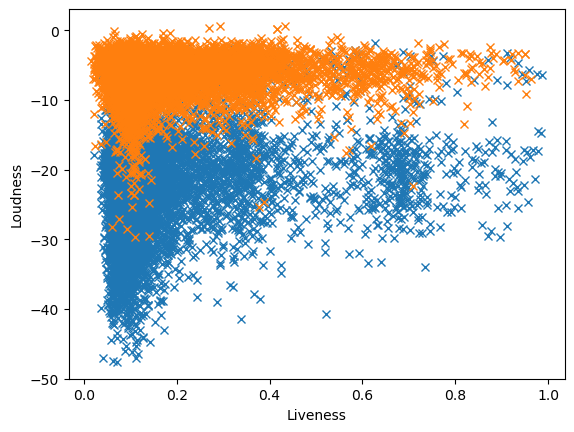

In [44]:
# Plotting the data
liveness_classical = input[:nb_classical, 0]
loudness_classical = input[:nb_classical, 1]
plt.plot(liveness_classical, loudness_classical, 'x')

liveness_pop = input[nb_classical:, 0]
loudness_pop = input[nb_classical:, 1]
plt.plot(liveness_pop, loudness_pop, 'x')

plt.xlabel("Liveness")
plt.ylabel("Loudness")
plt.show()

From the plot, we can see that while there is some overlap, Pop and Classical tracks tend to cluster based on their liveness and loudness but it will be impossible to classify them perfectly because the distribution are overlapping, but we could do something correct enough. Maybe if we add an other feature we could have better results.

Next we need to implement the logistic discrimination classifier, to do so, i will first implement the loss function, his derivative and an accuracy function

In [45]:
def loss(output, target):
    loss = 0
    for i in range(0,output.shape[0]):
        if target[i] == 0:
            loss += - m.log10(1 - output[i] + 1e-10)
        else:
            loss += - m.log10(output[i] + 1e-10)
    return loss

def derivative_loss(input, output, target):
    temp = np.hstack((input,np.ones((input.shape[0], 1))))
    return (temp.transpose() @ (output - target))

def accuracy(output, target):
    accuracy = 0
    for i in range(0,output.shape[0]):
        if round(output[i]) == target[i]:
            accuracy += 1
    accuracy = accuracy/output.shape[0]
    return accuracy

Now i will use a new class to do the classifier. The slop and the intercept will be only vector as we can add ones to the input and take the intercept as a slope for those ones.

In [46]:
class Classifier:
    def __init__(self, learning_rate, nb_epoch, loss, derivative_loss):
        self.parameters = np.ones((1,3))
        self.learning_rate = learning_rate
        self.nb_epoch = nb_epoch
        self.losses = []
        self.loss = loss
        self.derivative_loss = derivative_loss

    def test(self, input):
        temp = self.parameters @ (np.hstack((input,np.ones((input.shape[0], 1))))).transpose()
        output = 1 / ( 1 + np.exp(-temp[0]))
        return output
    
    def train(self, input, target):
        for i in range(0, self.nb_epoch):
            shuffle_index = np.random.permutation(input.shape[0])
            input_shuffled = input[shuffle_index]
            target_shuffled = target[shuffle_index]
            output = self.test(input_shuffled)
            self.losses.append(self.loss(output, target_shuffled))
            d_loss = self.derivative_loss(input_shuffled, output, target_shuffled)
            self.parameters = self.parameters - self.learning_rate * d_loss

    def plot_loss(self):
        plt.plot(range(0,self.nb_epoch), self.losses)
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.grid("true")
        plt.show()

And finally we can use our classifier on our data, and test the accuracy.

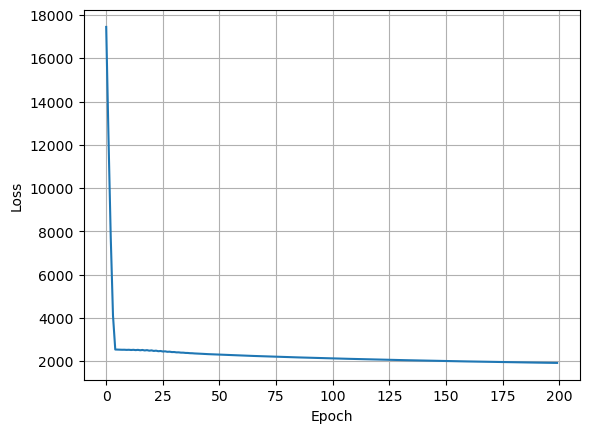

The accuracy of the classifier on the train set is 92.08020386266095 %
The accuracy of the classifier on the test set is 91.95710455764075 %


In [47]:
# Definition of the hyperparameters
classifier = Classifier(0.000005, 200, loss, derivative_loss)

# Training
classifier.train(input_train, target_train)
classifier.plot_loss()

# Testing
output_train = classifier.test(input_train)
acc = accuracy(output_train, target_train)
print("The accuracy of the classifier on the train set is", acc * 100, "%")
output_test = classifier.test(input_test)
acc = accuracy(output_test, target_test)
print("The accuracy of the classifier on the test set is", acc * 100, "%")

The accuracy is 91.8% on the training set which is good, it is slightly bigger on the training set, it is normal but there isn't a great difference because the data are well shuffle.
The loss is decreasing really fast at the beginning and the it start to stabilize, we could do more epochs but the loss won't decrease much and it will take much more time. So at chose to stop a 200 epochs. We can also see that the learning rate is good because if we try a bigger learning rate, the loss start oscillating around the minimum, that means the rate is too big. 

Here is an example with a bigger learning rate:

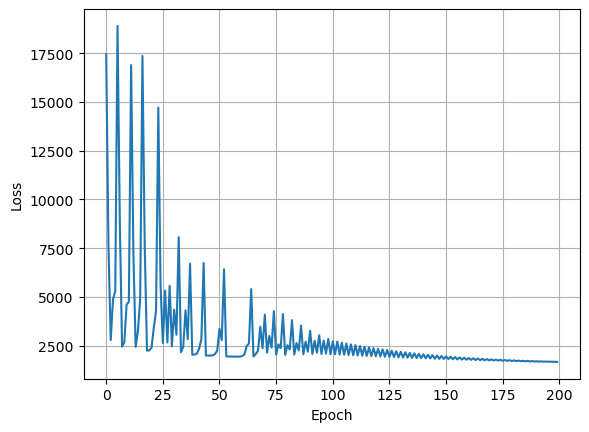

The accuracy of the classifier is 91.5549597855228 %


In [48]:
# Definition of the hyperparameters
classifier = Classifier(0.00001, 200, loss, derivative_loss)

# Training
classifier.train(input_train, target_train)
classifier.plot_loss()

# Testing
output_test = classifier.test(input_test)
acc = accuracy(output_test, target_test)
print("The accuracy of the classifier is", acc * 100, "%")

We can plot the line that our model found between pop and classical to see how it separate the clusters

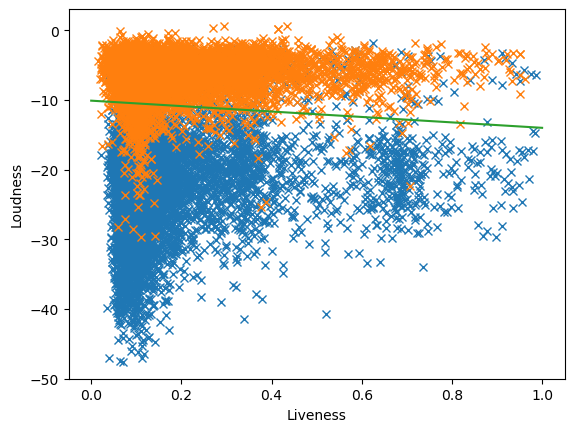

In [49]:
# Plotting the data
liveness_classical = input[:nb_classical, 0]
loudness_classical = input[:nb_classical, 1]
plt.plot(liveness_classical, loudness_classical, 'x')

liveness_pop = input[nb_classical:, 0]
loudness_pop = input[nb_classical:, 1]
plt.plot(liveness_pop, loudness_pop, 'x')

#Plotting the classifier
a1, a2, b = classifier.parameters[0]
liveness_line = np.linspace(0, 1, 1000)
loudness_line = - (liveness_line * a1 + b) / a2
plt.plot(liveness_line, loudness_line)

plt.xlabel("Liveness")
plt.ylabel("Loudness")

plt.show()

Next we can do the confusion matrix to see how good our classifier is, for that we can just do a loop, same as accuracy but counting all true positive, true negative, false positive and false negative.

In [50]:
def confusion(output, target):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(0,output.shape[0]):
        if(round(output[i])):
            if(target[i]):
                tp += 1
            else:
                fp += 1
        else:
            if(target[i]):
                fn += 1
            else:
                tn += 1
    return np.array([[tp, fn], [fp, tn]])

And now we can try our confusion matrix on our test of the classifier.

In [51]:
print("Confusion matrix :\n", confusion(output_test, target_test))

Confusion matrix :
 [[1746  132]
 [ 183 1669]]


There are a lot of false positive, more than false negative, that means a lot of pop tracks are classify as classical tracks. It can be explain by the fact that pop tracks cover a lot more diversity in term of liveness and loudness than classical tracks, that's why a lot of them are misclassify.

The confusion matrix give us more information than the accuracy, as it tells us exactly what are the mistakes, if the tracks that are misclassify are more pop tracks or classical tracks, and same for the well classify tracks, so we can adjust our classifier to consider that. For example in situation where we want really few false negative, in medical tests for example, we could know exactly how many false negative there are and we can adjust as we want.

If we want some classical songs that a pop fan would like, we can adjust the loss function, add weight to make our classifier give us less false positive, so less classical tracks that are classify as pop tracks, but those ones will be the ones that a pop fan would love.

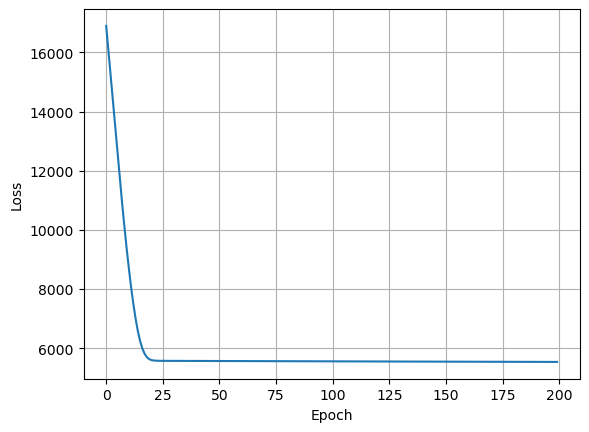

The accuracy of the classifier on the test set is 62.06434316353887 %
Confusion matrix :
 [[ 524 1354]
 [  61 1791]]


In [52]:
# Definition of a weight loss
def weight_loss(output, target):
    loss = 0
    for i in range(0,output.shape[0]):
        if target[i] == 0:
            loss += - 10 * m.log10(1 - output[i] + m.exp(-10))
        else:
            loss += - m.log10(output[i] + m.exp(-10))
    return loss

def weight_derivative_loss(input, output, target):
    temp = np.hstack((input,np.ones((input.shape[0], 1))))
    error = (output - target)
    for i in range(0,output.shape[0]):
        if target[i] == 0:
            error[i] = error[i] * 10
    return (temp.transpose() @ error)

# Definition of the hyperparameters
classifier = Classifier(0.000001, 200, weight_loss, weight_derivative_loss)

# Training
classifier.train(input_train, target_train)
classifier.plot_loss()

# Testing
output_test = classifier.test(input_test)
acc = accuracy(output_test, target_test)
print("The accuracy of the classifier on the test set is", acc * 100, "%")

print("Confusion matrix :\n", confusion(output_test, target_test))

Of course the accuracy will not be as good as before but if we look at the confusion matrix, there will be a lot less false positive, and we could even get the list to give it to a pop fan. Those songs are the few orange point under the green line.

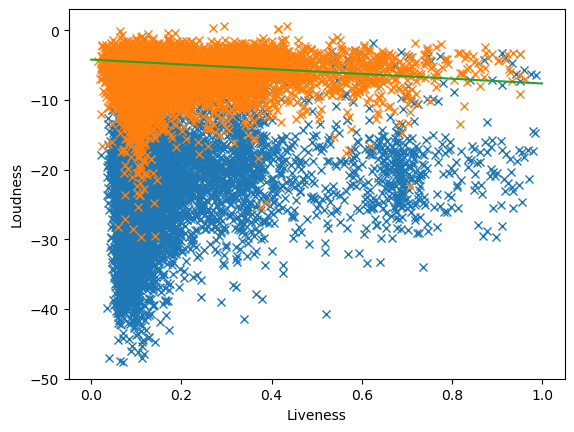

In [53]:
# Plotting the data
liveness_classical = input[:nb_classical, 0]
loudness_classical = input[:nb_classical, 1]
plt.plot(liveness_classical, loudness_classical, 'x')

liveness_pop = input[nb_classical:, 0]
loudness_pop = input[nb_classical:, 1]
plt.plot(liveness_pop, loudness_pop, 'x')

#Plotting the classifier
a1, a2, b = classifier.parameters[0]
liveness_line = np.linspace(0, 1, 1000)
loudness_line = - (liveness_line * a1 + b) / a2
plt.plot(liveness_line, loudness_line)

plt.xlabel("Liveness")
plt.ylabel("Loudness")

plt.show()

In [54]:
# Giving the classifier every song
output = classifier.test(input)

# Listing those who are false positive (we never modify the input, so it is in the the order as our tracks tables !)
false_negative = []
for i in range(0,output.shape[0]):
        if(round(output[i])):
            if(target[i] == 0):
                false_negative.append(np_track_table[i])

'If I Could Fly' and 'Starry Night' by Joe Satriani are the music i would recommended, Satriani is a really good guitarist.